# Figure 10: SMYLE Terrestrial Water Storage (TWS) potential predictability

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Data I/O using Dask

### Create Dask Cluster

In [54]:
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/wor

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

### Read in CLM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [5]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    d0 = cal.time_set_midmonth(ds0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time']]
    d0 = d0.chunk({'L':-1})
    return d0

In [6]:
# SMYLE-NOV TWS data
field = 'TWS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.clm2.h0.'
filetemplate = datadir+casename+'/lnd/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 11
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

5.308428272

In [7]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()
daskout = wait(smyle11_seas)

CPU times: user 42.7 s, sys: 745 ms, total: 43.4 s
Wall time: 48.1 s


In [8]:
# SMYLE-FEB TWS data
startmonth = 2
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

5.308428272

In [9]:
%%time
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()
daskout = wait(smyle02_seas)

CPU times: user 46 s, sys: 811 ms, total: 46.8 s
Wall time: 50.7 s


In [10]:
# SMYLE-MAY TWS data
startmonth = 5
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle05.nbytes/1e9 #GB

5.308428272

In [11]:
%%time
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()
daskout = wait(smyle05_seas)

CPU times: user 49.1 s, sys: 889 ms, total: 50 s
Wall time: 53 s


In [12]:
# SMYLE-AUG TWS data
startmonth = 8
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle08.nbytes/1e9 #GB

5.308428272

In [13]:
%%time
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()
daskout = wait(smyle08_seas)

CPU times: user 55 s, sys: 1.07 s, total: 56 s
Wall time: 1min


### Store datasets to disk for quicker processing next time (note this takes 20 minutes)

In [14]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11_seas.to_netcdf(outdir+'SMYLE11_TWS_seas.nc')
smyle02_seas.to_netcdf(outdir+'SMYLE02_TWS_seas.nc')
smyle05_seas.to_netcdf(outdir+'SMYLE05_TWS_seas.nc')
smyle08_seas.to_netcdf(outdir+'SMYLE08_TWS_seas.nc')

CPU times: user 7min 12s, sys: 10.7 s, total: 7min 23s
Wall time: 19min 30s


In [5]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
smyle11_seas = xr.open_dataset(outdir+'SMYLE11_TWS_seas.nc')
smyle02_seas = xr.open_dataset(outdir+'SMYLE02_TWS_seas.nc')
smyle05_seas = xr.open_dataset(outdir+'SMYLE05_TWS_seas.nc')
smyle08_seas = xr.open_dataset(outdir+'SMYLE08_TWS_seas.nc')

### Regrid Hindcast data

In [6]:
## Define 3x3 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,93,3),'lon':np.arange(0,360,3)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)

In [7]:
smyle11_seas = regrid.add_grid_bounds(smyle11_seas)
smyle02_seas = regrid.add_grid_bounds(smyle02_seas)
smyle05_seas = regrid.add_grid_bounds(smyle05_seas)
smyle08_seas = regrid.add_grid_bounds(smyle08_seas)

In [8]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(smyle11_seas, destgrid, 'conservative', periodic=True)

In [9]:
%%time
thresh = 0.6
smyle11_da = regrid_cam1deg(smyle11_seas.TWS,skipna=True, na_thres=thresh)
smyle02_da = regrid_cam1deg(smyle02_seas.TWS,skipna=True, na_thres=thresh)
smyle05_da = regrid_cam1deg(smyle05_seas.TWS,skipna=True, na_thres=thresh)
smyle08_da = regrid_cam1deg(smyle08_seas.TWS,skipna=True, na_thres=thresh)

CPU times: user 1min 28s, sys: 12.8 s, total: 1min 40s
Wall time: 1min 48s


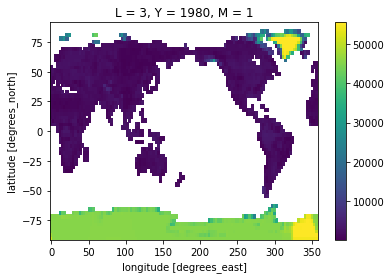

In [10]:
smyle11_da.isel(Y=10,L=0,M=0).plot();

### Get results from CLM5 land-only to assess potential predictability

In [13]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/'
fin = 'smyle_Transient.clm2.h0.TWS.185001-201812.nc'
#ds_clm = time_set_mid(xr.open_dataset(obs_dir+fin,decode_times=True),'time')
ds_clm = xr.open_dataset(obs_dir+fin,decode_times=False)
clm_montime_vals = [cftime.DatetimeNoLeap(1850+year, 1+month, 15) for year in range(169) for month in range(12)]
ds_clm['time'] = clm_montime_vals
ds_clm = ds_clm.sel(time=slice('1960','2018'))
ds_clm['time']

<xarray.DataArray 'time' (time: 708)>
array([cftime.DatetimeNoLeap(1960, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00

In [14]:
obs_seas = ds_clm.TWS.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

### Regrid land-only "observations"

In [15]:
obs_seas = regrid.add_grid_bounds(obs_seas.to_dataset())

In [16]:
%%time
obs_seas = regrid_cam1deg(obs_seas.TWS,skipna=True, na_thres=thresh)

CPU times: user 1.11 s, sys: 139 ms, total: 1.24 s
Wall time: 1.33 s


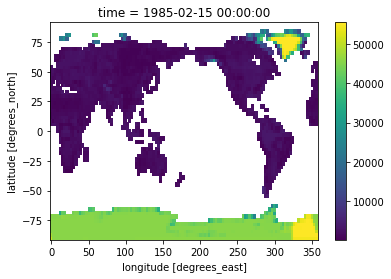

In [17]:
obs_seas.isel(time=300).plot()

## Get CESM2-LE Data

In [18]:
import intake

catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
col = intake.open_esm_datastore(catalog_file)
cesm2data = col.search(component='lnd', 
                       variable=['TWS'], 
                       frequency='month_1', 
                       experiment=['historical','ssp370'], 
                       forcing_variant='smbb')

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [19]:
## The following is needed as a workaround for this issue with intake-esm:
## https://github.com/intake/intake-esm/issues/343
cesm2data.df = cesm2data.df.sort_values(by=['time_range'])

# Test that it gets timestamps in order:
#cesm2data.df[cesm2data.df.experiment == 'historical']

In [20]:
%%time
## Use preprocessor to return mid-month time
def preproc(ds):
    ds = cal.time_set_midmonth(ds,'time')
    return ds

dask.config.set(**{'array.slicing.split_large_chunks': True})
dsets = cesm2data.to_dataset_dict(preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 12.9 s, sys: 497 ms, total: 13.4 s
Wall time: 28.2 s


In [21]:
dsets.keys()

dict_keys(['lnd.ssp370.clm2.h0.smbb.TWS', 'lnd.historical.clm2.h0.smbb.TWS'])

In [22]:
# Compute CESM2-LE mean over 50 members:
cesm2_hist = dsets['lnd.historical.clm2.h0.smbb.TWS'].TWS
cesm2_ssp = dsets['lnd.ssp370.clm2.h0.smbb.TWS'].TWS
cesm2_tws = xr.concat([cesm2_hist,cesm2_ssp],dim='time').mean('member_id').persist()

In [23]:
cesm2_tws

<xarray.DataArray 'TWS' (time: 3012, lat: 192, lon: 288)>
dask.array<mean_agg-aggregate, shape=(3012, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) object 1850-01-15 00:00:00 ... 2100-12-15 00:00:00

In [24]:
cesm2_tws_seas = cesm2_tws.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

In [25]:
%%time
cesm2_tws = regrid_cam1deg(cesm2_tws_seas,skipna=True, na_thres=thresh)

CPU times: user 1.85 s, sys: 19.8 ms, total: 1.87 s
Wall time: 2.24 s


# Skill Analysis

In [26]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1972
climy1 = 2017
smyle11_time = smyle11_seas.time.load()
smyle02_time = smyle02_seas.time.load()
smyle05_time = smyle05_seas.time.load()
smyle08_time = smyle08_seas.time.load()
smyle11_anom,smyle11_clim = stats.remove_drift(smyle11_da,smyle11_time,climy0,climy1)
smyle02_anom,smyle02_clim = stats.remove_drift(smyle02_da,smyle02_time,climy0,climy1)
smyle05_anom,smyle05_clim = stats.remove_drift(smyle05_da,smyle05_time,climy0,climy1)
smyle08_anom,smyle08_clim = stats.remove_drift(smyle08_da,smyle08_time,climy0,climy1)

CPU times: user 2.67 s, sys: 800 ms, total: 3.47 s
Wall time: 3.65 s


In [27]:
%%time
smyle11_anom = smyle11_anom.load()
smyle02_anom = smyle02_anom.load()
smyle05_anom = smyle05_anom.load()
smyle08_anom = smyle08_anom.load()

CPU times: user 228 µs, sys: 28 µs, total: 256 µs
Wall time: 259 µs


In [28]:
%%time
smyle11_skill = stats.compute_skill_seasonal(smyle11_anom,smyle11_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle02_skill = stats.compute_skill_seasonal(smyle02_anom,smyle02_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle05_skill = stats.compute_skill_seasonal(smyle05_anom,smyle05_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle08_skill = stats.compute_skill_seasonal(smyle08_anom,smyle08_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)

CPU times: user 37.6 s, sys: 77.7 ms, total: 37.7 s
Wall time: 39.5 s


In [29]:
# Mask Antarctica
smyle11_skill = smyle11_skill.where(smyle11_skill.lat>-60.)
smyle02_skill = smyle02_skill.where(smyle02_skill.lat>-60.)
smyle05_skill = smyle05_skill.where(smyle05_skill.lat>-60.)
smyle08_skill = smyle08_skill.where(smyle08_skill.lat>-60.)

In [30]:
# Zero out ACC where insignificant
siglvl = 0.1
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle02_skill['corr'] = smyle02_skill.corr.where(smyle02_skill.pval<siglvl)
smyle05_skill['corr'] = smyle05_skill.corr.where(smyle05_skill.pval<siglvl)
smyle08_skill['corr'] = smyle08_skill.corr.where(smyle08_skill.pval<siglvl)

## Focus on high JJA skill over Southwest CONUS

CPU times: user 67.3 ms, sys: 2.95 ms, total: 70.3 ms
Wall time: 248 ms


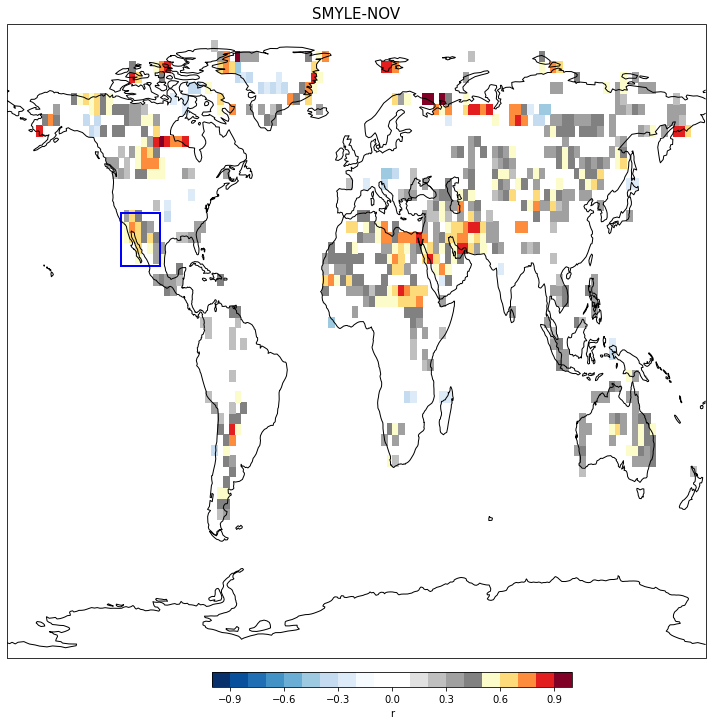

In [32]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(10,10))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
cmap = "blue2red_acc"
coff = 0.5
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

ax4,cntr4 = maps.map_pcolor_global_subplot(fig, smyle11_skill.corr.isel(L=6), smyle11_skill.lon, smyle11_skill.lat,
                                       ci,cmin,cmax,colstr[3],1,1,1,proj,cmap=cmap,cutoff=coff)
#ldstr = ltime[6] + ': ' + str(smyle11_skill.isel(L=6).season.values)
#ax4.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')

ax4.add_patch(mpatches.Rectangle(xy=[-120, 22], width=20, height=15,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))

fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr4, cax=cbar_ax, label='r', orientation='horizontal')

In [40]:
# SW regional-average
region1lonlat = [-120.,-100.,22.,37.]  
region1title = 'SW'

tmp = obs_seas.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_reg = tmp.weighted(wgts).mean(("lon", "lat"))

tmp = smyle11_anom.isel(L=6).mean('M').sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
smyle_tws = tmp.weighted(wgts).mean(("lon", "lat")).rename({'Y':'time'})
smyle_tws['time'] = smyle11_time.isel(L=6).dt.year.values

In [41]:
# CESM2-LE regional-average
keep = cesm2_tws.time.dt.month==7
tmp = cesm2_tws.isel(time=keep).sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
cesm2le_jja = tmp.weighted(wgts).mean(("lon", "lat")).load()
cesm2le_jja['time'] = tmp.time.dt.year.values
cesm2le_jja = cesm2le_jja - cesm2le_jja.sel(time=slice(climy0,climy1)).mean('time')

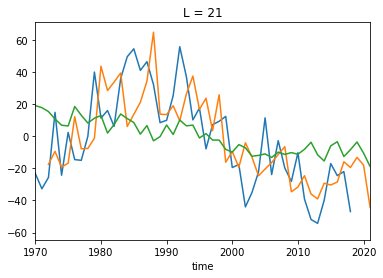

In [43]:
keep = obs_reg_anom.time.dt.month==7
tmp = obs_reg_anom.isel(time=keep)
tmp = tmp - tmp.sel(time=slice(str(climy0),str(climy1))).mean('time')
tmp['time'] = tmp.time.dt.year
tmp.plot(xlim=[1970,2021])
smyle_tws.plot()
cesm2le_jja.plot()

In [44]:
%%time
smyle11_reg = smyle11_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle11_reg = smyle11_reg.weighted(wgts).mean(("lon", "lat"))
smyle02_reg = smyle02_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle02_reg = smyle02_reg.weighted(wgts).mean(("lon", "lat"))
smyle05_reg = smyle05_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle05_reg = smyle05_reg.weighted(wgts).mean(("lon", "lat"))
smyle08_reg = smyle08_anom.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(360+region1lonlat[0],360+region1lonlat[1]))
smyle08_reg = smyle08_reg.weighted(wgts).mean(("lon", "lat"))

CPU times: user 26.6 ms, sys: 0 ns, total: 26.6 ms
Wall time: 27.6 ms


In [45]:
%%time
smyle11_skill_reg = stats.compute_skill_seasonal(smyle11_reg,smyle11_time,obs_reg,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle02_skill_reg = stats.compute_skill_seasonal(smyle02_reg,smyle02_time,obs_reg,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle05_skill_reg = stats.compute_skill_seasonal(smyle05_reg,smyle05_time,obs_reg,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle08_skill_reg = stats.compute_skill_seasonal(smyle08_reg,smyle08_time,obs_reg,str(climy0),str(climy1),1,8,resamp=0,detrend=True)

CPU times: user 612 ms, sys: 1.92 ms, total: 614 ms
Wall time: 633 ms


### Create Persistence scores from autocorrelation of smoothed Trendy data

##### Method:  Persist JJA anomalies (corresponding to lead times of 9-months and 21-months)

In [46]:
import xskillscore as xs
obs1 = obs_reg.sel(time=slice("1970","2019"))
obs_jja =  obs1.where(obs1.time.dt.month==7).dropna('time')
obs_jja_dt = stats.detrend_linear(obs_jja, 'time')
obs_jja_ac1 = xs.pearson_r(obs_jja_dt,obs_jja_dt.shift(time=1),'time',skipna=True)
obs_jja_ac2 = xs.pearson_r(obs_jja_dt,obs_jja_dt.shift(time=2),'time',skipna=True)

cesm2_dt = stats.detrend_linear(cesm2le_jja.sel(time=slice(1970,2018)), 'time')
cesm2_dt['time'] = obs_jja_dt['time']
cesm2_acc = xs.pearson_r(obs_jja_dt,cesm2_dt,'time',skipna=True)
cesm2_rmse = xs.rmse(obs_jja_dt,cesm2_dt,dim='time')/obs_jja_dt.std('time')

In [47]:
cesm2_acc

<xarray.DataArray ()>
array(0.10001682)
Coordinates:
    L        int64 21

In [48]:
%%time
smyle11_skill = smyle11_skill.load()
smyle02_skill = smyle02_skill.load()
smyle05_skill = smyle05_skill.load()
smyle08_skill = smyle08_skill.load()
smyle11_skill_reg = smyle11_skill_reg.load()
smyle02_skill_reg = smyle02_skill_reg.load()
smyle05_skill_reg = smyle05_skill_reg.load()
smyle08_skill_reg = smyle08_skill_reg.load()

CPU times: user 358 µs, sys: 32 µs, total: 390 µs
Wall time: 392 µs


CPU times: user 519 ms, sys: 79.9 ms, total: 599 ms
Wall time: 634 ms


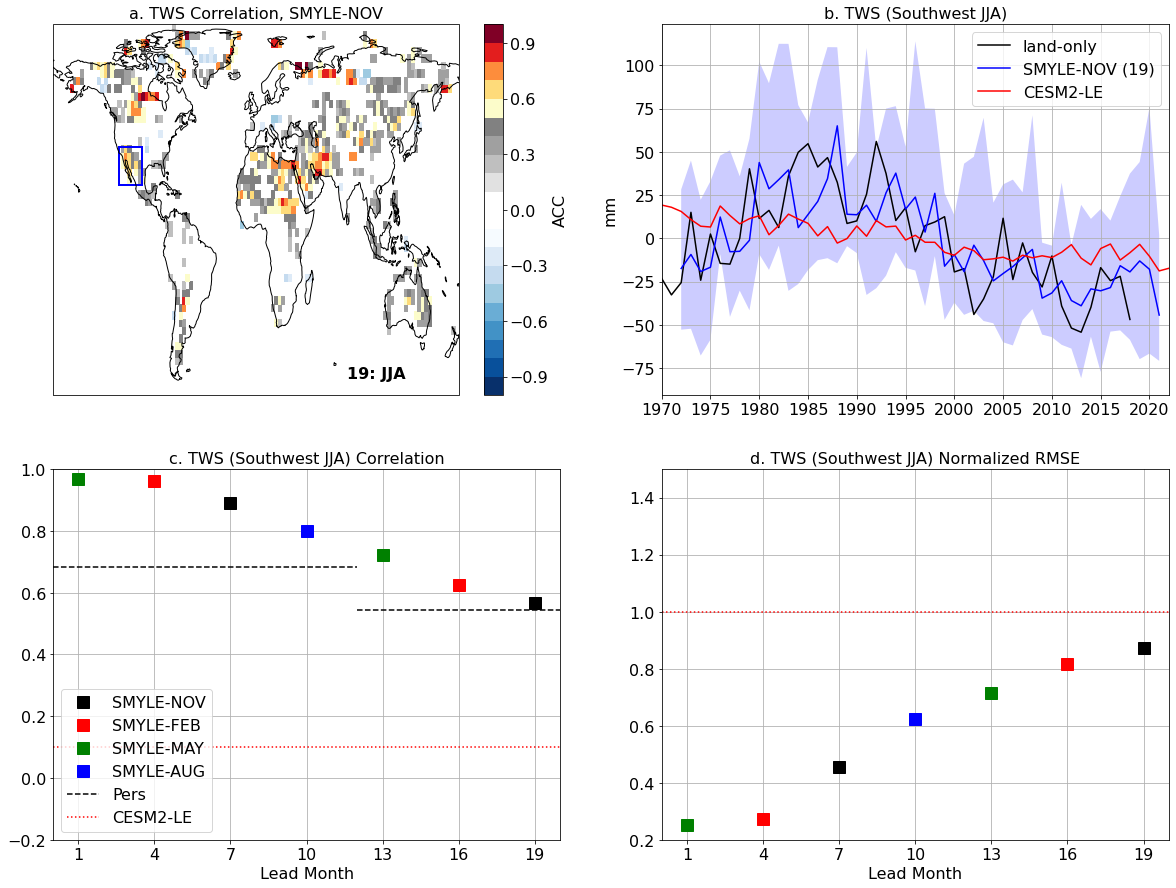

In [53]:
%%time
import matplotlib.patches as mpatches
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(20,15))
nrow=2
ncol=2
plt.rcParams.update({'font.size': 16})

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
seas11dict = {1:'DJF',4:'MAM',7:'JJA',10:'SON',13:'DJF',16:'MAM',19:'JJA'}
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=16
fweight='bold'
cmap = "blue2red_acc"
coff = 0.5
xloc = 80
yloc = -55

tmp = smyle11_skill.corr.isel(L=6).sel(lat=slice(-60,85))
ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp, tmp.lon, tmp.lat,
                                       ci,cmin,cmax,colstr[3],nrow,ncol,1,proj,cmap=cmap,cutoff=coff)
ldstr = ltime[6] + ': ' + seas11dict[smyle11_time.isel(L=6).dt.month.values[0]]
ax1.text(xloc,yloc,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white')
ax1.add_patch(mpatches.Rectangle(xy=[-120, 22], width=20, height=15,facecolor='None',edgecolor='blue',lw=2,
                                    alpha=1.,
                                    transform=proj))
ax1.set_title('a. TWS Correlation, SMYLE-NOV',loc='center',fontsize=fsize)
fig.colorbar(cntr1, ax=ax1, label='ACC')

ax2 = fig.add_subplot(nrow,ncol,2)
keep = obs_reg.time.dt.month==7
tmp = obs_reg.isel(time=keep)
tmp = tmp - tmp.sel(time=slice(str(climy0),str(climy1))).mean('time')
tmp['time'] = tmp.time.dt.year
ax2.plot(tmp.time,tmp,color='k',label='land-only')
ax2.plot(smyle11_time.isel(L=6).dt.year,smyle11_reg.mean('M').isel(L=6),color='b',label='SMYLE-NOV (19)')
ymin = smyle11_reg.min('M').isel(L=6)
ymax = smyle11_reg.max('M').isel(L=6)
ax2.fill_between(smyle11_time.isel(L=6).dt.year,ymin,ymax,fc='b',alpha=0.2)
ax2.plot(cesm2le_jja.time,cesm2le_jja,color='r',label='CESM2-LE')
ax2.legend(loc='upper right')
ax2.set_xticks(np.arange(1970,2025,5))
ax2.grid(True)
ax2.set_xlim([1970,2022])
ax2.set_title('b. TWS (Southwest JJA)',loc='center',fontsize=fsize)
#ax2.set_xlabel('Year')
ax2.set_ylabel('mm')
#ax2.set_ylim([-0.2,1])

ax3 = fig.add_subplot(nrow,ncol,3)
leadmon = smyle11_skill_reg.L-2
seasons = ['DJF','MAM','JJA','SON']
markers = ['D','o','s','P']
#ax3.set_ylabel('Correlation', fontsize=14)
ax3.set_title('c. TWS (Southwest JJA) Correlation',loc='center',fontsize=fsize)
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_time.isel(Y=0).dt.month.values==7),color='k',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle11_skill_reg.corr.where(smyle11_time.isel(Y=0).dt.month.values==7).where(smyle11_skill_reg.pval<0.1),color='k',marker='s',ms=12,label='SMYLE-NOV',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_time.isel(Y=0).dt.month.values==7),color='r',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle02_skill_reg.corr.where(smyle02_time.isel(Y=0).dt.month.values==7).where(smyle02_skill_reg.pval<0.1),color='r',marker='s',ms=12,label='SMYLE-FEB',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_time.isel(Y=0).dt.month.values==7),color='g',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle05_skill_reg.corr.where(smyle05_time.isel(Y=0).dt.month.values==7).where(smyle05_skill_reg.pval<0.1),color='g',marker='s',ms=12,label='SMYLE-MAY',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_time.isel(Y=0).dt.month.values==7),color='b',marker='s',fillstyle='none',linestyle='none')
ax3.plot(leadmon,smyle08_skill_reg.corr.where(smyle08_time.isel(Y=0).dt.month.values==7).where(smyle08_skill_reg.pval<0.1),color='b',marker='s',ms=12,label='SMYLE-AUG',linestyle='none')
#ax3.plot(leadmon[0:7],pers_skill,color='k',linestyle='dashed',label='Pers')
ax3.plot([0,12],[obs_jja_ac1,obs_jja_ac1],color='k',linestyle='dashed',label='Pers')
ax3.plot([12,20],[obs_jja_ac2,obs_jja_ac2],color='k',linestyle='dashed')
ax3.plot([0,20],[cesm2_acc,cesm2_acc],color='r',label='CESM2-LE',linestyle='dotted')
ax3.legend(loc='lower left',ncol=1)
ax3.set_xticks(leadmon)
ax3.grid(True)
ax3.set_xlim([0,20])
ax3.set_ylim([-0.2,1])
ax3.set_xlabel('Lead Month')

ax4 = fig.add_subplot(nrow,ncol,4)
ax4.set_ylabel(r'', fontsize=14)
ax4.set_title('d. TWS (Southwest JJA) Normalized RMSE',loc='center',fontsize=fsize)
ax4.plot(leadmon,smyle11_skill_reg.rmse.where(smyle11_time.isel(Y=0).dt.month.values==7),color='k',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle02_skill_reg.rmse.where(smyle02_time.isel(Y=0).dt.month.values==7),color='r',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle05_skill_reg.rmse.where(smyle05_time.isel(Y=0).dt.month.values==7),color='g',marker='s',ms=12,linestyle='none')
ax4.plot(leadmon,smyle08_skill_reg.rmse.where(smyle08_time.isel(Y=0).dt.month.values==7),color='b',marker='s',ms=12,linestyle='none')
ax4.plot([0,20],[cesm2_rmse,cesm2_rmse],color='r',linestyle='dotted')
ax4.set_xticks(leadmon)
ax4.grid(True)
ax4.set_xlim([0,20])
ax4.set_ylim([0.2,1.5])
ax4.set_xlabel('Lead Month')

plt.savefig('f10.png')